In [33]:
import os, sys
sys.path.append("../src")
import numpy as np
from utils.vit_util import ViTExperiment
import datasets
from datasets import Dataset, DatasetInfo, DatasetDict, load_dataset
from PIL import Image
# datasetをロード (初回の読み込みだけやや時間かかる)
cifar10 = load_dataset("cifar10")
cifar10["train"]

Found cached dataset parquet (/root/.cache/huggingface/datasets/parquet/plain_text-d4c080360fb556b0/0.0.0/14a00e99c0d15a23649d0db8944380ac81082d4b021f398733dd84f3a6c569a7)


  0%|          | 0/2 [00:00<?, ?it/s]

Dataset({
    features: ['img', 'label'],
    num_rows: 50000
})

In [ ]:
dataset_dir = ViTExperiment.DATASET_DIR
c10c_raw_dir = os.path.join(dataset_dir, "c10c/raw_data")

In [21]:
def arr2img(arr):
    """
    (n, h, w, c)の形状のnumpy配列をn個のPIL.Imageのリストに変換して返す
    """
    imgs = []
    for a in arr:
        imgs.append(Image.fromarray(a))
    return imgs

In [22]:
# c10c_raw_dir直下のnpyファイルのリストを取得
npy_files = [f for f in os.listdir(c10c_raw_dir) if f.endswith(".npy")]
# .npy以前の名前をキーとしてDatasetDictを作成する
ds_dict = {}
for npy_file in npy_files:
    key = npy_file.split(".npy")[0]
    if key == "labels":
        labels = np.load(os.path.join(c10c_raw_dir, npy_file))
        continue
    ds_arr = np.load(os.path.join(c10c_raw_dir, npy_file))
    print(ds_arr.shape)
    # ここでnumpy.arrayからPIL Imageに変換することでcifar10のオリジナルと同じ形式にする
    ds_dict[key] = arr2img(ds_arr)
    print(f"{key}: {ds_arr.shape}")
print("labels =", labels)

(50000, 32, 32, 3)
defocus_blur: (50000, 32, 32, 3)
(50000, 32, 32, 3)
jpeg_compression: (50000, 32, 32, 3)
(50000, 32, 32, 3)
zoom_blur: (50000, 32, 32, 3)
(50000, 32, 32, 3)
gaussian_noise: (50000, 32, 32, 3)
(50000, 32, 32, 3)
gaussian_blur: (50000, 32, 32, 3)
(50000, 32, 32, 3)
spatter: (50000, 32, 32, 3)
(50000, 32, 32, 3)
contrast: (50000, 32, 32, 3)
(50000, 32, 32, 3)
brightness: (50000, 32, 32, 3)
(50000, 32, 32, 3)
shot_noise: (50000, 32, 32, 3)
(50000, 32, 32, 3)
snow: (50000, 32, 32, 3)
(50000, 32, 32, 3)
frost: (50000, 32, 32, 3)
(50000, 32, 32, 3)
fog: (50000, 32, 32, 3)
(50000, 32, 32, 3)
motion_blur: (50000, 32, 32, 3)
(50000, 32, 32, 3)
saturate: (50000, 32, 32, 3)
(50000, 32, 32, 3)
pixelate: (50000, 32, 32, 3)
(50000, 32, 32, 3)
impulse_noise: (50000, 32, 32, 3)
(50000, 32, 32, 3)
elastic_transform: (50000, 32, 32, 3)
(50000, 32, 32, 3)
glass_blur: (50000, 32, 32, 3)
(50000, 32, 32, 3)
speckle_noise: (50000, 32, 32, 3)
labels = [3 8 8 ... 5 1 7]


defocus_blur 8 ship


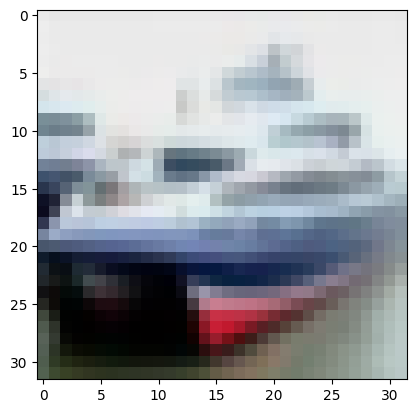

jpeg_compression 8 ship


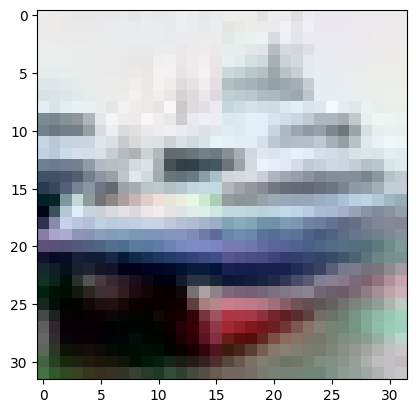

zoom_blur 8 ship


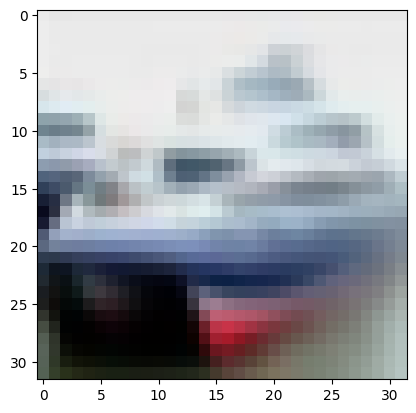

gaussian_noise 8 ship


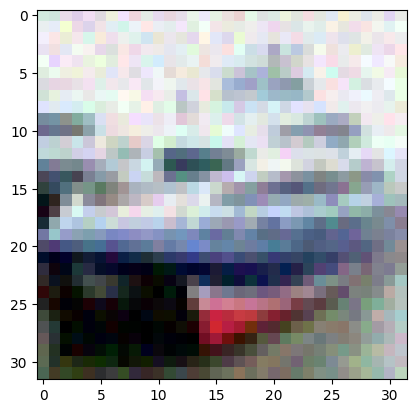

gaussian_blur 8 ship


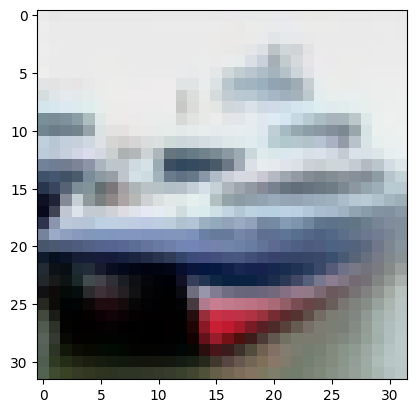

spatter 8 ship


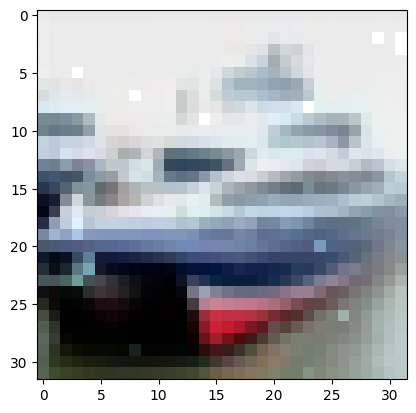

contrast 8 ship


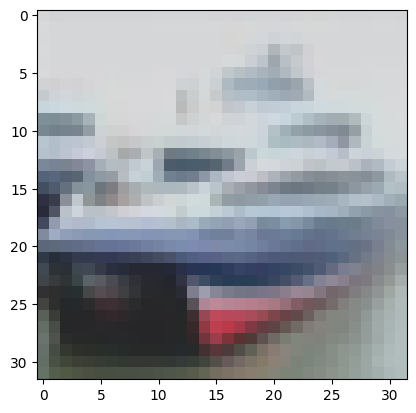

brightness 8 ship


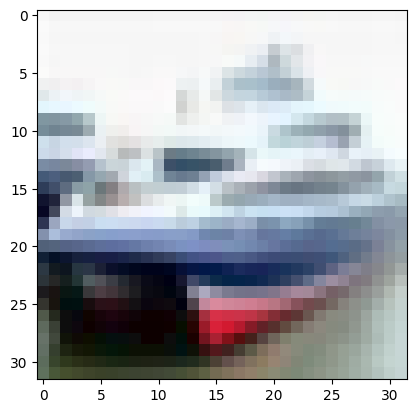

shot_noise 8 ship


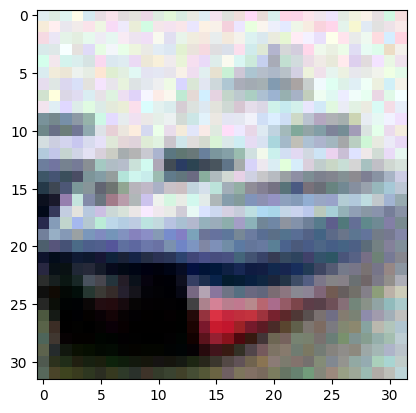

snow 8 ship


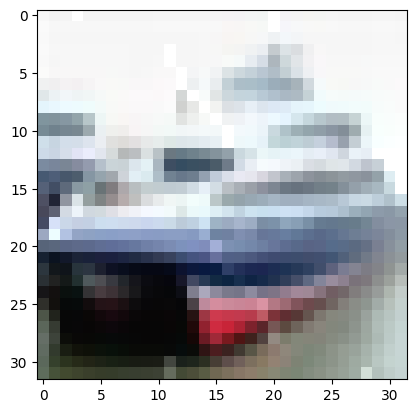

frost 8 ship


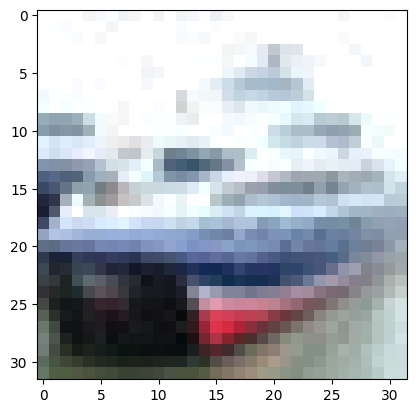

fog 8 ship


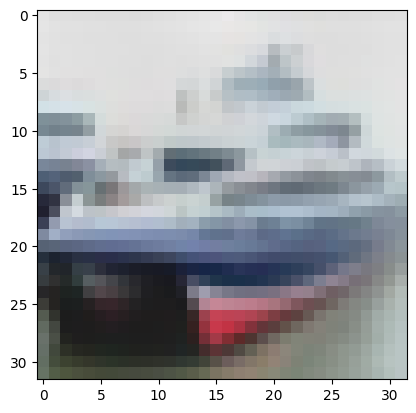

motion_blur 8 ship


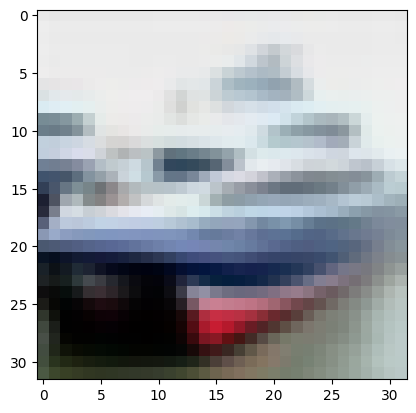

saturate 8 ship


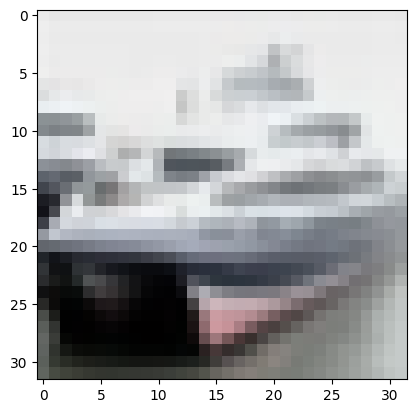

pixelate 8 ship


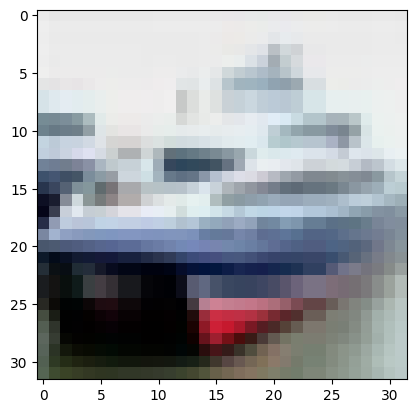

impulse_noise 8 ship


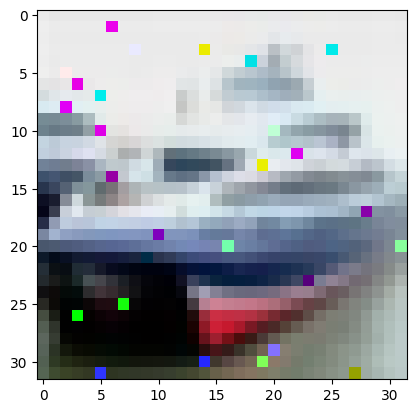

elastic_transform 8 ship


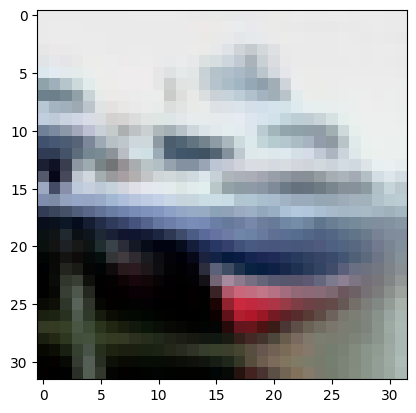

glass_blur 8 ship


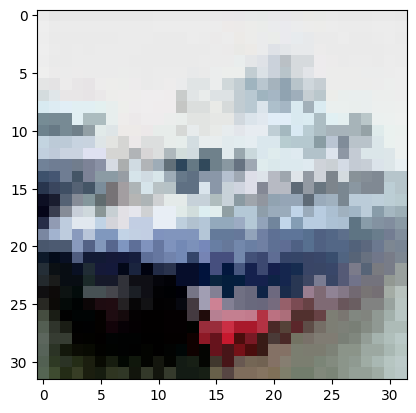

speckle_noise 8 ship


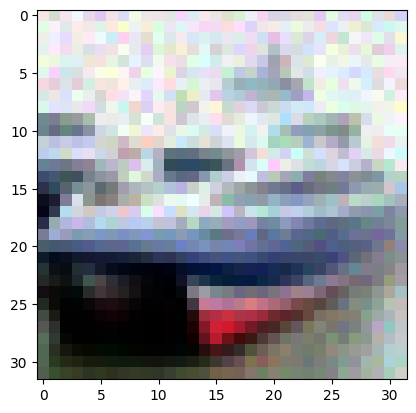

In [25]:
# ds_dictの各画像の1番目を表示したい
import matplotlib.pyplot as plt
idx = 1
for k, v in ds_dict.items():
    print(k, labels[idx], cifar10["train"].features["label"].int2str(int(labels[idx])))
    plt.imshow(v[idx])
    plt.show()

In [5]:
ds_ori = cifar10["train"]
ds_ori

Dataset({
    features: ['img', 'label'],
    num_rows: 50000
})

In [37]:
info = DatasetInfo(
    features=datasets.Features(
        {
            "img": ds_ori.features["img"],
            "label": ds_ori.features["label"],
        }
    ),
)

In [38]:
key = "zoom_blur"
ds = Dataset.from_dict({"img": ds_dict[key], "label": labels}, info=info)
ds

Dataset({
    features: ['img', 'label'],
    num_rows: 50000
})

In [30]:
from transformers import ViTImageProcessor

# 今回は https://huggingface.co/google/vit-base-patch16-224-in21k を利用
model_name_or_path = 'google/vit-base-patch16-224-in21k'
processor = ViTImageProcessor.from_pretrained(model_name_or_path)

In [42]:
# 前処理を5件のサンプルに適用してみる
processed_imgs = processor(images=ds[:5]["img"], return_tensors="pt")
processed_imgs["pixel_values"].shape # (batch, channel, height, width)になっている

torch.Size([5, 3, 224, 224])

In [41]:
# 前処理を5件のサンプルに適用してみる
processed_imgs = processor(images=ds_ori[:5]["img"], return_tensors="pt")
processed_imgs["pixel_values"].shape # (batch, channel, height, width)になっている

torch.Size([5, 3, 224, 224])

In [47]:
a = DatasetDict({})
a

DatasetDict({
    
})

In [45]:
# aにvalidationというキーを追加
a["validation"] = ds

In [46]:
a

DatasetDict({
    train: Dataset({
        features: ['img', 'label'],
        num_rows: 50000
    })
    test: Dataset({
        features: ['img', 'label'],
        num_rows: 50000
    })
    validation: Dataset({
        features: ['img', 'label'],
        num_rows: 50000
    })
})